In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
#database_path = "pets_db"
#engine = create_engine(f"sqlite:///{database_path}")


# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
recent_date.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x231f156d8e0>,
 'date': '2017-08-23',
 'tobs': 81.0,
 'id': 2724,
 'prcp': 0.0,
 'station': 'USC00519397'}

In [10]:
for row in session.query(Measurement).order_by(Measurement.id.desc()).all():
    print(row.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F156D880>, 'date': '2017-08-23', 'tobs': 76.0, 'id': 19550, 'prcp': 0.45, 'station': 'USC00516128'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F15833D0>, 'date': '2017-08-22', 'tobs': 76.0, 'id': 19549, 'prcp': 0.5, 'station': 'USC00516128'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F15833A0>, 'date': '2017-08-21', 'tobs': 76.0, 'id': 19548, 'prcp': 0.56, 'station': 'USC00516128'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F15834F0>, 'date': '2017-08-20', 'tobs': 78.0, 'id': 19547, 'prcp': None, 'station': 'USC00516128'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F1583DF0>, 'date': '2017-08-19', 'tobs': 71.0, 'id': 19546, 'prcp': 0.09, 'station': 'USC00516128'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F1583A90>, 'date': '2017-08

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F21F0C40>, 'date': '2010-06-25', 'tobs': 71.0, 'id': 15128, 'prcp': 0.02, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F21F0CD0>, 'date': '2010-06-24', 'tobs': 75.0, 'id': 15127, 'prcp': 0.0, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F21F0D60>, 'date': '2010-06-23', 'tobs': 76.0, 'id': 15126, 'prcp': 0.0, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F21F0DF0>, 'date': '2010-06-22', 'tobs': 76.0, 'id': 15125, 'prcp': 0.0, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F21F0E80>, 'date': '2010-06-21', 'tobs': 77.0, 'id': 15124, 'prcp': 0.0, 'station': 'USC00511918'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F21F0F10>, 'date': '2010-06-20

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F26CD970>, 'date': '2014-07-03', 'tobs': 76.0, 'id': 11129, 'prcp': 0.1, 'station': 'USC00519523'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F26CDA00>, 'date': '2014-07-02', 'tobs': 82.0, 'id': 11128, 'prcp': 0.0, 'station': 'USC00519523'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F26CDA90>, 'date': '2014-07-01', 'tobs': 79.0, 'id': 11127, 'prcp': 0.0, 'station': 'USC00519523'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F26CDB20>, 'date': '2014-06-30', 'tobs': 76.0, 'id': 11126, 'prcp': 0.07, 'station': 'USC00519523'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F26CDBB0>, 'date': '2014-06-29', 'tobs': 74.0, 'id': 11125, 'prcp': 0.01, 'station': 'USC00519523'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F26CDC40>, 'date': '2014-06-2

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F2B6DF10>, 'date': '2016-07-28', 'tobs': 81.0, 'id': 7311, 'prcp': 0.05, 'station': 'USC00514830'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F2B6DFA0>, 'date': '2016-07-27', 'tobs': 82.0, 'id': 7310, 'prcp': 0.0, 'station': 'USC00514830'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F2B75070>, 'date': '2016-07-25', 'tobs': 77.0, 'id': 7309, 'prcp': None, 'station': 'USC00514830'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F2B75100>, 'date': '2016-07-22', 'tobs': 78.0, 'id': 7308, 'prcp': 0.0, 'station': 'USC00514830'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F2B75190>, 'date': '2016-07-20', 'tobs': 79.0, 'id': 7307, 'prcp': 0.0, 'station': 'USC00514830'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000231F2B75220>, 'date': '2016-07-19', '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
# Find the most recent date in the data set.
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
earliest_date

('2010-01-01',)

In [12]:
#find data types

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [26]:
# Starting from the most recent data point in the database. 
session.query(Measurement.date).filter(Measurement.id ==(19550)).order_by(Measurement.date).first()

('2017-08-23',)

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#session.query(Measurement.date).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all()


#q.filter(or_(Table.value.between(100, 230)

# Calculate the date one year from the last date in data set.
session.query(Measurement.date).filter(Measurement.id >= (19202)).order_by(Measurement.date).first()

# Perform a query to retrieve the data and precipitation scores
year_data = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).filter(Measurement.id >= (19202)).all()
year_data
# Save the query results as a Pandas DataFrame and set the index to the date column
year_df = pd.DataFrame(year_data)
year_df.set_index('date',inplace=True)

year_df.sort_index
year_df


# Sort the dataframe by date
#DataFrameName.set_index(“column_name_to_setas_Index”,inplace=True/False)





#grouped_dates = year_df.groupby("date")

#grouped_df = grouped_dates.sum()


#grouped_df = grouped_df.loc[(grouped_df('id') > 2016-8-23) & (grouped_df('date') <= 2017-8-23)]
#grouped_df

,prcp
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-27,NaN
2016-08-28,2.07
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [70]:
# Perform a query to retrieve the data and precipitation scores
year_data2 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.id >= (19202)).order_by(Measurement.date).all()
year_data2
# Save the query results as a Pandas DataFrame and set the index to the date column
year_df2 = pd.DataFrame(year_data2)
year_df2.set_index('date',inplace=True)

year_df2.sort_index
year_df2


# Sort the dataframe by date

grouped_dates = year_df2.groupby(['date'])

year_df = grouped_dates.mean()
year_df = year_df.rename(columns={"prcp":"Precipitation"})
year_df

,Precipitation
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-27,NaN
2016-08-28,2.07
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [71]:
x_axis = np.arange(len(year_df))
tick_locations = [value for value in x_axis]

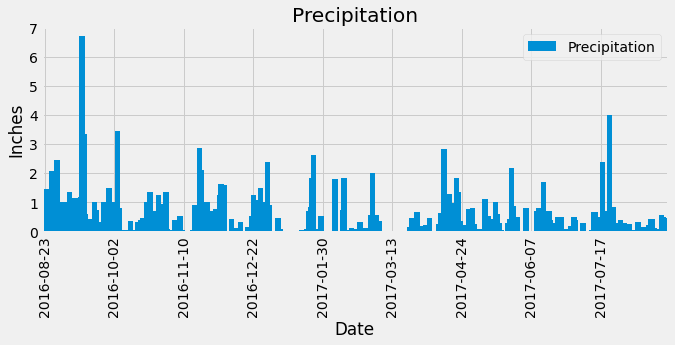

<Figure size 432x288 with 0 Axes>

In [72]:
chart = year_df.plot(kind="bar", figsize=(10,3.5),width=3, label='precipitation')
plt.title("Precipitation")
plt.locator_params(axis='x', nbins=9)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation="vertical")
chart.legend()
plt.ylim(0,7)
plt.show()
plt.tight_layout()

In [69]:
# Use Pandas to calcualte the summary statistics for the precipitation data
grouped_df.describe()

,prcp
count,328.000000
mean,0.450640
std,0.717174
min,0.000000
25%,0.010000
50%,0.190000
75%,0.610000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
first_station = session.query(Station).
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x231f344efa0>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [21]:
# Close Session
session.close()